# Background

This notebook performs background exploration for the ViolentRiskFactors project.

Specifically, we examine properties of the literature related to violence and delinquency risk factors, such as which risk factor categories are most frequently mentioned, how their prevalence changes over time, and what general associations appear in the literature.

Note: To re-run this notebook, the same relative structure as the project repository is assumed, including the data directory.

In [1]:
%matplotlib inline

import csv
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lisc.collect import collect_info, collect_counts
from lisc.plts.utils import get_cmap
from lisc.plts.words import plot_years
from lisc.plts.counts import plot_matrix

/Users/davidgallardo-pujol/Documents/GitHub/ViolentRiskFactors/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Import custom project code
import sys
sys.path.append('../code')
from plts import plot_year_comparison

## Settings

Settings for the current collection & analyses.

Note that to re-run this notebook, it assumes the same relative structure as the project repository, including the data directory. 

In [9]:
# Notebook settings
SAVE_FIG = False
SAVE_DATA = True
RUN_COLLECTION = True

In [10]:
# Set the location of the data directory 
data_dir = Path('../data/data/background')
figs_dir = Path('../data/figures/background')

In [11]:
# Plot settings
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'

## Meta Data

Collect meta data information about the database we're collecting from, as a log for the collections in this notebook.

In [12]:
# Ensure the data directory exists
if not data_dir.exists():
    data_dir.mkdir(parents=True, exist_ok=True)

meta_file = data_dir / 'meta_data.json'

# Collect meta data information for current collections
if RUN_COLLECTION:
    meta_data = collect_info()
    
    # Save out meta data information
    if SAVE_DATA:
        with open(meta_file, 'w') as save_file:
            json.dump(meta_data.as_dict(), save_file)
else:
    if meta_file.exists():
        with open(meta_file, 'r') as f_obj:
            meta_data = json.load(f_obj)
    else:
        print("Warning: The file meta_data.json does not exist. Please run the collection (set RUN_COLLECTION = True) or create the file.")
        meta_data = {}  # o gestiona el cas segons el que necessitis

/Users/davidgallardo-pujol/Documents/GitHub/ViolentRiskFactors/.venv/lib/python3.9/site-packages/lisc/collect/info.py:88: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  info_page_soup = BeautifulSoup(info_page.content, 'lxml')


In [13]:
# Check the meta data for the collection
meta_data

{'date': '2025-02-07_22:47:02', 'log': None, 'requester_n_requests': 1, 'requester_wait_time': 0.3333333333333333, 'requester_start_time': '22:47:02 Friday 07 February 2025', 'requester_end_time': '22:47:03 Friday 07 February 2025', 'requester_logging': None, 'db_info_dbname': 'pubmed', 'db_info_menuname': 'PubMed', 'db_info_description': 'PubMed bibliographic record', 'db_info_dbbuild': 'Build-2025.02.06.23.07', 'db_info_count': '38365935', 'db_info_lastupdate': '2025/02/06 23:07'}

## Categories

First, lets collect some basic information on different categories of risk factors.

In [33]:
# Defineix categories de factors de risc amb sinònims
risk_factor_terms = [
    ['individual', 'personal traits', 'psychological factors', 'cognitive factors'],
    ['familial', 'family environment', 'parental influence', 'childhood abuse'],
    ['social', 'peer influence', 'community', 'socioeconomic status', 'neighborhood'],
    ['situational', 'criminogenic', 'acute stressors', 'access to weapons', 'substance abuse']
]

# Defineix etiquetes curtes per a cada categoria
risk_factor_labels = [lst[0] for lst in risk_factor_terms]

In [34]:
# Collect data for the number of papers found for each risk factor category
if RUN_COLLECTION:
    risk_factor_count, _ = collect_counts(risk_factor_terms, collect_coocs=False)
    
    # Save out the collected data for the risk factor counts
    if SAVE_DATA:
        with open(data_dir / 'risk_factor_counts.csv', 'w') as save_file:
            for label, count in zip(risk_factor_labels, risk_factor_count):
                save_file.write(label + ',' + str(count) + '\n')

else:
    with open(data_dir / 'risk_factor_counts.csv', 'r') as f_obj:
        risk_factor_count = np.array([row[1] for row in csv.reader(f_obj)], dtype='int')


In [35]:
# Check the number of articles found for each risk factor category
print('Number of articles found for each risk factor category:')
for label, count in zip(risk_factor_labels, risk_factor_count):
    print('\t', label, '\t', count)

Number of articles found for each risk factor category:
	 individual 	 1110906
	 familial 	 136916
	 social 	 1485692
	 situational 	 44619


## Risk Factors Across Time

Next, we can examine the different risk factors across time. 

To do so, we will re-run the same search as above, repeated for recent decades, to compare risk factor prevalence and trends over time.

In [36]:
# Define the range of the decades to collect information on for risk factors
start_decade, end_decade = 1950, 2020
decades = list(range(start_decade, end_decade, 10))


In [38]:
# Collect information across each decade of interest for risk factors
if RUN_COLLECTION:
    
    decade_counts = []
    for start_year in decades:

        count, _ = collect_counts(risk_factor_terms,
                                  collect_coocs=False,
                                  mindate=str(start_year) + '/01/01',
                                  maxdate=str(start_year+9) + '/12/31')
        decade_counts.append(count)

    # Convert the collected data into an array, of [n_terms, decade_counts]
    decade_counts = np.array(decade_counts).T
    
    if SAVE_DATA:
        # Ensure the 'decades' directory exists
        (data_dir / 'decades').mkdir(parents=True, exist_ok=True)
        
        # Save out the collected data for the risk factor counts by decade
        for ind, label in enumerate(risk_factor_labels):
            for decade, count in zip(decades, decade_counts):
                with open(data_dir / 'decades' / (label + '.csv'), 'w') as save_file:
                    for decade, count in zip(decades, decade_counts[ind, :]):
                        save_file.write(str(decade) + ',' + str(count) + '\n')
                        
else:
    decade_counts = []
    for r_term in risk_factor_labels:
        with open(data_dir / 'decades'/ (r_term + '.csv'), 'r') as f_obj:
            count = np.array([row[1] for row in csv.reader(f_obj)], dtype='int')
        decade_counts.append(count)
    decade_counts = np.array(decade_counts)


In [40]:
# Check the sum of the risk factors across decades
#   Note that this should approximate the total counts from above
print('Number of articles, collapsed across years, for each risk factor category:')
for label, count in zip(risk_factor_labels, np.sum(decade_counts, 1)):
    print('\t', label, '\t', count)

Number of articles, collapsed across years, for each risk factor category:
	 individual 	 804054
	 familial 	 113605
	 social 	 961363
	 situational 	 34873


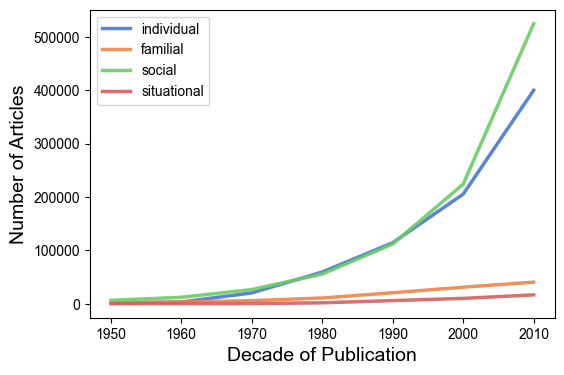

In [41]:
# Plot the popularity of each risk factor category across the decades
plot_year_comparison(decades, decade_counts, risk_factor_labels,
                     save_fig=SAVE_FIG, file_name='risk_factor_decades.pdf', directory=figs_dir)


## Number of Risk Factor Papers

Next, let's examine research on risk factors for violence and recidivism. First, we can collect the total number of papers that discuss risk factors.


In [45]:
# Define risk factor related search terms with expanded synonyms
risk_factor_term = [["violence risk factor", "recidivism risk factor", "criminogenic factors", 
                     "criminal risk factor", "offender risk factors", "predictors of violence", 
                     "risk factors for reoffending", "delinquency predictors", "crime-related risk factors", 
                     "criminogenic needs", "violent behavior predictors", "antisocial risk factors"]]


In [46]:
# Collect count of the number of papers mentioning risk factors
if RUN_COLLECTION:
    risk_factor_count, meta_data = collect_counts(risk_factor_term, collect_coocs=False)
    
    if SAVE_DATA:        
        # Save out the collected data for the risk factor count
        with open(data_dir / 'risk_factor_count.csv', 'w') as save_file:
            save_file.write('risk_factors' + ',' + str(risk_factor_count[0]) + '\n')

else:
    with open(data_dir / 'risk_factor_count.csv', 'r') as f_obj:
        risk_factor_count = np.array([row[1] for row in csv.reader(f_obj)], dtype='int')


In [47]:
# Check the total number of risk factor papers found
print('Number of risk factor papers: \t', risk_factor_count[0])

Number of risk factor papers: 	 40173


## Violence and recidivism risk factors research across years

Next, we can examine violence and recidivism research across time, by collecting the number of papers discussing those risk factors, per year.

In [48]:
# Define range of years to collect data for
start_year, end_year = 1960, 2021

In [49]:
# Collect count of the number of risk factor related papers per year
if RUN_COLLECTION:
    
    year_counts = {}
    for year in range(start_year, end_year):
        temp_count, _ = collect_counts(risk_factor_term, collect_coocs=False, 
                                       mindate=str(year) + '/01/01',
                                       maxdate=str(year) + '/12/31')
        year_counts[year] = temp_count[0]
        
    # Save out the collected data for the risk factor counts by year
    if SAVE_DATA:
        with open(data_dir / 'risk_factor_years.csv', 'w') as save_file:
            for year, count in year_counts.items():
                save_file.write(str(year) + ',' + str(count) + '\n')
                
else:
    with open(data_dir / 'risk_factor_years.csv', 'r') as f_obj:
        year_counts = {int(row[0]) : int(row[1]) for row in csv.reader(f_obj)}


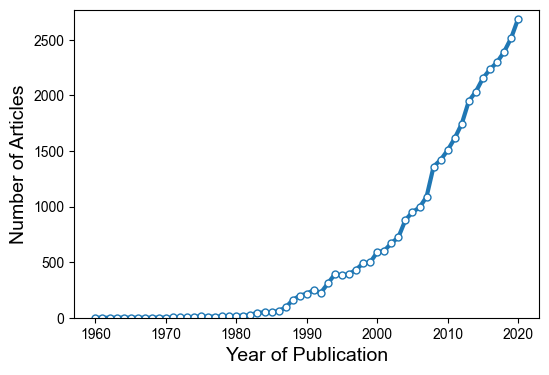

In [50]:
# Plot the number of risk factor papers per year
plot_years(year_counts, fontsize=14, figsize=(6, 4),
           save_fig=SAVE_FIG, file_name='risk_factor_years.pdf', directory=figs_dir)


## ERP Associations

Finally, we can do a quick scan of some common general associations of ERP-related work. 

To do so, we will define some very general association terms, and see how often these terms co-occur with ERP research.

In [51]:
# Defineix alguns termes generals d'associació per a la reincidència i la violència
assoc_terms = [['psychopathology', 'mental disorder', 'personality disorder'],
               ['substance use', 'drug abuse', 'alcohol abuse'], 
               ['criminal justice', 'prison system', 'incarceration', 'probation', 'parole'], 
               ['social integration', 'rehabilitation', 'reentry', 'desistance'],
               ['economic factors', 'poverty', 'unemployment', 'financial hardship'],
               ['family environment', 'parenting', 'childhood trauma'],
               ['peer influence', 'gang affiliation', 'social networks'],
               ['criminogenic needs', 'antisocial behavior', 'impulsivity', 'self-control']]
               
# Defineix una llista d'etiquetes per als termes d'associació
assoc_labels = [term[0] for term in assoc_terms]


In [52]:
# Collect counts of the number of risk factor papers that co-occur with general association terms
if RUN_COLLECTION:
    coocs, counts, meta_data = collect_counts(risk_factor_term, terms_b=assoc_terms)
    
    # Save out the collected data for the association counts
    if SAVE_DATA:
        with open(data_dir / 'risk_factor_association_counts.csv', 'w') as save_file:
            for label, count in zip(assoc_labels, coocs[0, :]):
                save_file.write(label + ',' + str(count) + '\n')
                
else:
    with open(data_dir / 'risk_factor_association_counts.csv', 'r') as f_obj:
        coocs = np.reshape(np.array([row[1] for row in csv.reader(f_obj)], dtype='int'), (-1, 1)).T


/Users/davidgallardo-pujol/Documents/GitHub/ViolentRiskFactors/.venv/lib/python3.9/site-packages/lisc/plts/counts.py:75: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


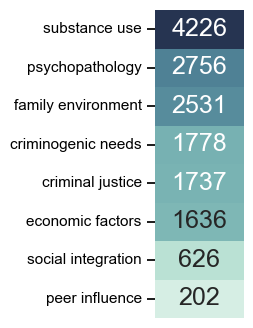

In [55]:
# Sort the matrix from largest to smallest
sorted_indices = np.argsort(-coocs[0, :])
coocs = coocs[:, sorted_indices]
assoc_labels = [assoc_labels[i] for i in sorted_indices]

# Plot a visualization of the counts of risk factor papers per association topic
plot_matrix(coocs.T, [], assoc_labels, cmap='blue', figsize=(1.15, 4),
            cbar=False, annot=True, annot_kws={"size": 18}, fmt='d', 
            save_fig=SAVE_FIG, file_name='risk_factor_associations.pdf', directory=figs_dir)

## Conclusion

From these background checks, we can see that research on risk factors for violence and recidivism is extensive and continues to be relevant across various domains. This motivates the rest of the project – to dig deeper into the literature, analyze trends, and further characterize these risk factors.
